In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, Callback
from keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, imagenet_utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy

In [2]:
# variables used in each process
input_shape_2D = (224, 224)
input_shape_3D = (224, 224, 3)
seed = 1
batch_size = 32
epochs = 20

In [3]:
# reading the dataset to categorize it into training and validation data
data = tf.keras.utils.image_dataset_from_directory(
  directory="Rice Leafs Disease Dataset",
  labels="inferred",
  label_mode="int",
  color_mode="rgb",
  image_size=input_shape_2D,
  seed=seed,
  batch_size=batch_size,
  validation_split=0.2,
  subset="training"
)

val_data = tf.keras.utils.image_dataset_from_directory(
  directory="Rice Leafs Disease Dataset",
  labels="inferred",
  label_mode="int",
  color_mode="rgb",
  image_size=input_shape_2D,
  seed=seed,
  batch_size=batch_size,
  validation_split=0.2,
  subset="validation"
)

class_names = data.class_names
class_names

Found 2150 files belonging to 5 classes.
Using 1720 files for training.
Found 2150 files belonging to 5 classes.
Using 430 files for validation.


['bacterial', 'blast', 'brown', 'narrow', 'scald']

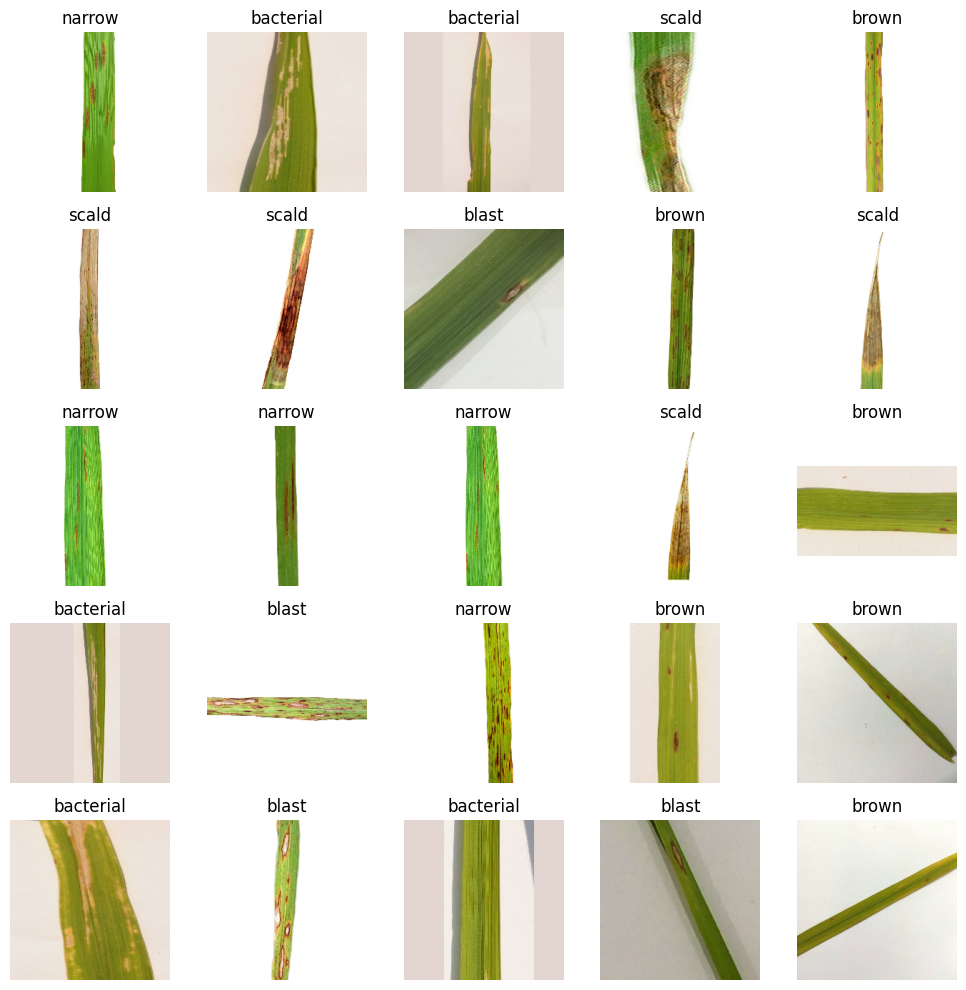

In [4]:
# Display some sample images
plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
  for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
  plt.tight_layout()

In [5]:
# Normalize the images
def preprocess(image, label):
  image = tf.cast(image, tf.float32) / 255.0
  return image, label

data = data.map(preprocess)
val_data = val_data.map(preprocess)

In [6]:
# Create the model VGG16
model = Sequential()

model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax')) 

model.compile(optimizer=Adam(learning_rate=0.0001), loss=sparse_categorical_crossentropy, metrics=["accuracy"])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                   

In [8]:
# Custom callback to compute precision, recall, and F1-score at the end of each epoch
class MetricsCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        y_pred = []
        y_true = []
        for images, labels in val_data:
            y_true.extend(labels.numpy())
            preds = model.predict(images)
            y_pred.extend(np.argmax(preds, axis=1))
        
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        
        logs['val_precision'] = precision
        logs['val_recall'] = recall
        logs['val_f1'] = f1
        
        print(f'Epoch {epoch+1}: val_precision={precision:.4f}, val_recall={recall:.4f}, val_f1={f1:.4f}')

metrics_callback = MetricsCallback()
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor="val_accuracy", save_best_only=True, save_weights_only=False, mode="max", verbose=1, period=1)
# lr_scheduler = LearningRateScheduler(lambda epoch: 1e-3 * 0.1 ** (epoch // 10))
early = EarlyStopping(monitor="val_accuracy", min_delta=0, patience=5, mode="auto", verbose=1)
hist = model.fit_generator(generator=data, validation_data=val_data, epochs=epochs, callbacks=[checkpoint, early, metrics_callback], verbose=1)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_16464\637890802.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(generator=data, validation_data=val_data, epochs=epochs, callbacks=[checkpoint, early, metrics_callback], verbose=1)


Epoch 1/20


54/54 [==============================] - ETA: 0s - loss: 1.6095 - accuracy: 0.1930 
Epoch 1: val_accuracy improved from -inf to 0.20465, saving model to vgg16_1.h5


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 3s 3s/step
Epoch 1: val_precision=0.0419, val_recall=0.2047, val_f1=0.0695
54/54 [==============================] - 3240s 60s/step - loss: 1.6095 - accuracy: 0.1930 - val_loss: 1.5974 - val_accuracy: 0.2047 - val_precision: 0.0419 - val_recall: 0.2047 - val_f1: 0.0695
Epoch 2/20


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


54/54 [==============================] - ETA: 0s - loss: 1.6096 - accuracy: 0.2012 
Epoch 2: val_accuracy did not improve from 0.20465
1/1 [==============================] - 3s 3s/step
Epoch 2: val_precision=0.0419, val_recall=0.2047, val_f1=0.0695
54/54 [==============================] - 2679s 50s/step - loss: 1.6096 - accuracy: 0.2012 - val_loss: 1.6022 - val_accuracy: 0.2047 - val_precision: 0.0419 - val_recall: 0.2047 - val_f1: 0.0695
Epoch 3/20


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


54/54 [==============================] - ETA: 0s - loss: 1.5998 - accuracy: 0.2209 
Epoch 3: val_accuracy improved from 0.20465 to 0.43721, saving model to vgg16_1.h5


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 3s 3s/step
Epoch 3: val_precision=0.2896, val_recall=0.4372, val_f1=0.3338
54/54 [==============================] - 2796s 52s/step - loss: 1.5998 - accuracy: 0.2209 - val_loss: 1.5241 - val_accuracy: 0.4372 - val_precision: 0.2896 - val_recall: 0.4372 - val_f1: 0.3338
Epoch 4/20


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


54/54 [==============================] - ETA: 0s - loss: 1.1625 - accuracy: 0.5291 
Epoch 4: val_accuracy improved from 0.43721 to 0.64884, saving model to vgg16_1.h5


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 2s 2s/step
Epoch 4: val_precision=0.6861, val_recall=0.6488, val_f1=0.6355
54/54 [==============================] - 2897s 54s/step - loss: 1.1625 - accuracy: 0.5291 - val_loss: 0.8840 - val_accuracy: 0.6488 - val_precision: 0.6861 - val_recall: 0.6488 - val_f1: 0.6355
Epoch 5/20
54/54 [==============================] - ETA: 0s - loss: 0.9598 - accuracy: 0.6128 
Epoch 5: val_accuracy improved from 0.64884 to 0.70698, saving model to vgg16_1.h5


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 2s 2s/step
Epoch 5: val_precision=0.7100, val_recall=0.7070, val_f1=0.6956
54/54 [==============================] - 2270s 42s/step - loss: 0.9598 - accuracy: 0.6128 - val_loss: 0.8677 - val_accuracy: 0.7070 - val_precision: 0.7100 - val_recall: 0.7070 - val_f1: 0.6956
Epoch 6/20
54/54 [==============================] - ETA: 0s - loss: 0.8657 - accuracy: 0.6500 
Epoch 6: val_accuracy did not improve from 0.70698
1/1 [==============================] - 3s 3s/step
Epoch 6: val_precision=0.7147, val_recall=0.6651, val_f1=0.6483
54/54 [==============================] - 2881s 54s/step - loss: 0.8657 - accuracy: 0.6500 - val_loss: 0.8564 - val_accuracy: 0.6651 - val_precision: 0.7147 - val_recall: 0.6651 - val_f1: 0.6483
Epoch 7/20
54/54 [==============================] - ETA: 0s - loss: 0.7622 - accuracy: 0.7105 
Epoch 7: val_accuracy did not improve from 0.70698
1/1 [==============================] - 2s 2s/step
Epoch 7: val_precision=0.7318, val_recall=

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 2s 2s/step
Epoch 8: val_precision=0.7937, val_recall=0.7721, val_f1=0.7608
54/54 [==============================] - 2445s 45s/step - loss: 0.5713 - accuracy: 0.7750 - val_loss: 0.5610 - val_accuracy: 0.7721 - val_precision: 0.7937 - val_recall: 0.7721 - val_f1: 0.7608
Epoch 9/20
54/54 [==============================] - ETA: 0s - loss: 0.4556 - accuracy: 0.8273 
Epoch 9: val_accuracy improved from 0.77209 to 0.84186, saving model to vgg16_1.h5


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 2s 2s/step
Epoch 9: val_precision=0.8540, val_recall=0.8419, val_f1=0.8420
54/54 [==============================] - 2217s 41s/step - loss: 0.4556 - accuracy: 0.8273 - val_loss: 0.4581 - val_accuracy: 0.8419 - val_precision: 0.8540 - val_recall: 0.8419 - val_f1: 0.8420
Epoch 10/20
54/54 [==============================] - ETA: 0s - loss: 0.4861 - accuracy: 0.8256 
Epoch 10: val_accuracy did not improve from 0.84186
1/1 [==============================] - 2s 2s/step
Epoch 10: val_precision=0.6715, val_recall=0.5721, val_f1=0.5499
54/54 [==============================] - 2095s 39s/step - loss: 0.4861 - accuracy: 0.8256 - val_loss: 1.1866 - val_accuracy: 0.5721 - val_precision: 0.6715 - val_recall: 0.5721 - val_f1: 0.5499
Epoch 11/20
54/54 [==============================] - ETA: 0s - loss: 0.6492 - accuracy: 0.7453 
Epoch 11: val_accuracy did not improve from 0.84186
1/1 [==============================] - 2s 2s/step
Epoch 11: val_precision=0.8090, val_r

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 2s 2s/step
Epoch 14: val_precision=0.8685, val_recall=0.8605, val_f1=0.8598
54/54 [==============================] - 2252s 42s/step - loss: 0.3115 - accuracy: 0.8936 - val_loss: 0.4383 - val_accuracy: 0.8605 - val_precision: 0.8685 - val_recall: 0.8605 - val_f1: 0.8598
Epoch 15/20
54/54 [==============================] - ETA: 0s - loss: 0.2760 - accuracy: 0.8965 
Epoch 15: val_accuracy did not improve from 0.86047
1/1 [==============================] - 2s 2s/step
Epoch 15: val_precision=0.8451, val_recall=0.8326, val_f1=0.8314
54/54 [==============================] - 2239s 41s/step - loss: 0.2760 - accuracy: 0.8965 - val_loss: 0.5422 - val_accuracy: 0.8326 - val_precision: 0.8451 - val_recall: 0.8326 - val_f1: 0.8314
Epoch 16/20
54/54 [==============================] - ETA: 0s - loss: 0.2166 - accuracy: 0.9180 
Epoch 16: val_accuracy improved from 0.86047 to 0.89767, saving model to vgg16_1.h5


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 3s 3s/step
Epoch 16: val_precision=0.9017, val_recall=0.8977, val_f1=0.8986
54/54 [==============================] - 2234s 41s/step - loss: 0.2166 - accuracy: 0.9180 - val_loss: 0.3464 - val_accuracy: 0.8977 - val_precision: 0.9017 - val_recall: 0.8977 - val_f1: 0.8986
Epoch 17/20
54/54 [==============================] - ETA: 0s - loss: 0.1721 - accuracy: 0.9366 
Epoch 17: val_accuracy did not improve from 0.89767
1/1 [==============================] - 3s 3s/step
Epoch 17: val_precision=0.8852, val_recall=0.8860, val_f1=0.8850
54/54 [==============================] - 2310s 43s/step - loss: 0.1721 - accuracy: 0.9366 - val_loss: 0.4016 - val_accuracy: 0.8860 - val_precision: 0.8852 - val_recall: 0.8860 - val_f1: 0.8850
Epoch 18/20
54/54 [==============================] - ETA: 0s - loss: 0.3312 - accuracy: 0.8797 
Epoch 18: val_accuracy did not improve from 0.89767
1/1 [==============================] - 3s 3s/step
Epoch 18: val_precision=0.8799, val_

In [41]:
# Predict the labels for the test set
y_true = np.concatenate([y for x, y in val_data], axis=0)
y_pred = model.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)

14/14 [==============================] - 44s 3s/step


In [51]:
# Store each epoch value in arrays and extract precision, recall, and f1-score per epoch from the history
epochs_range = range(1, len(hist.history['loss']) + 1)
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
val_precision = hist.history['val_precision']
val_recall = hist.history['val_recall']
val_f1 = hist.history['val_f1']

epochs_table_all = pd.DataFrame({
    'Epoch': epochs_range,
    'Train Loss': train_loss,
    'Val Loss': val_loss,
    'Train Accuracy': train_acc,
    'Val Accuracy': val_acc,
    'Val Precision': val_precision,
    'Val Recall': val_recall,
    'Val F1-Score': val_f1
})
epochs_table_all


,Epoch,Train Loss,Val Loss,Train Accuracy,Val Accuracy,Val Precision,Val Recall,Val F1-Score
0,1,1.610435,1.609607,0.199419,0.186047,0.034613,0.186047,0.058368
1,2,1.406644,0.956705,0.348256,0.595349,0.615542,0.595349,0.579443
2,3,1.040380,0.843378,0.556977,0.648837,0.680812,0.648837,0.637144
3,4,0.919459,0.837487,0.612209,0.660465,0.703875,0.660465,0.663449
4,5,0.859755,0.706192,0.647093,0.711628,0.709199,0.711628,0.700267
5,6,0.654175,0.546719,0.751163,0.788372,0.794923,0.788372,0.779202
6,7,0.550069,0.515713,0.783721,0.797674,0.811844,0.797674,0.792330
7,8,0.480368,0.485405,0.803488,0.800000,0.806753,0.800000,0.795650
8,9,0.393657,0.425684,0.851163,0.834884,0.848110,0.834884,0.834219
9,10,0.352657,0.360076,0.869186,0.867442,0.868284,0.867442,0.867291


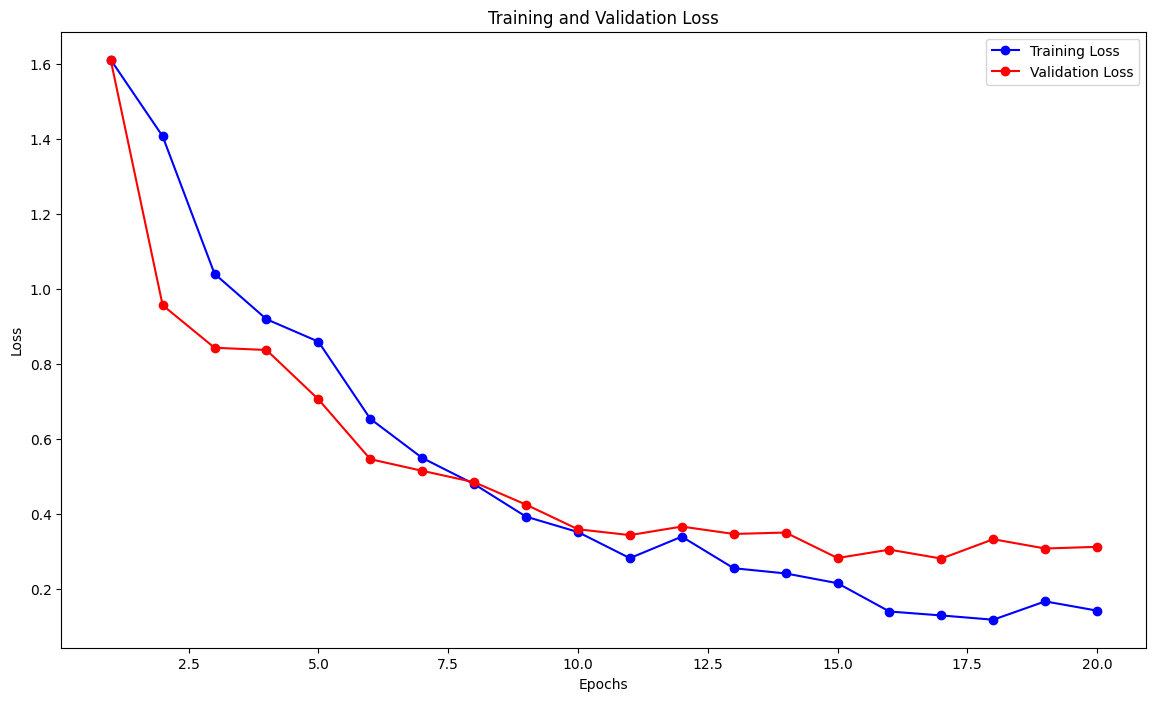

In [47]:
# Plotting the training and validation loss
plt.figure(figsize=(14, 8))
plt.plot(epochs_range, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs_range, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

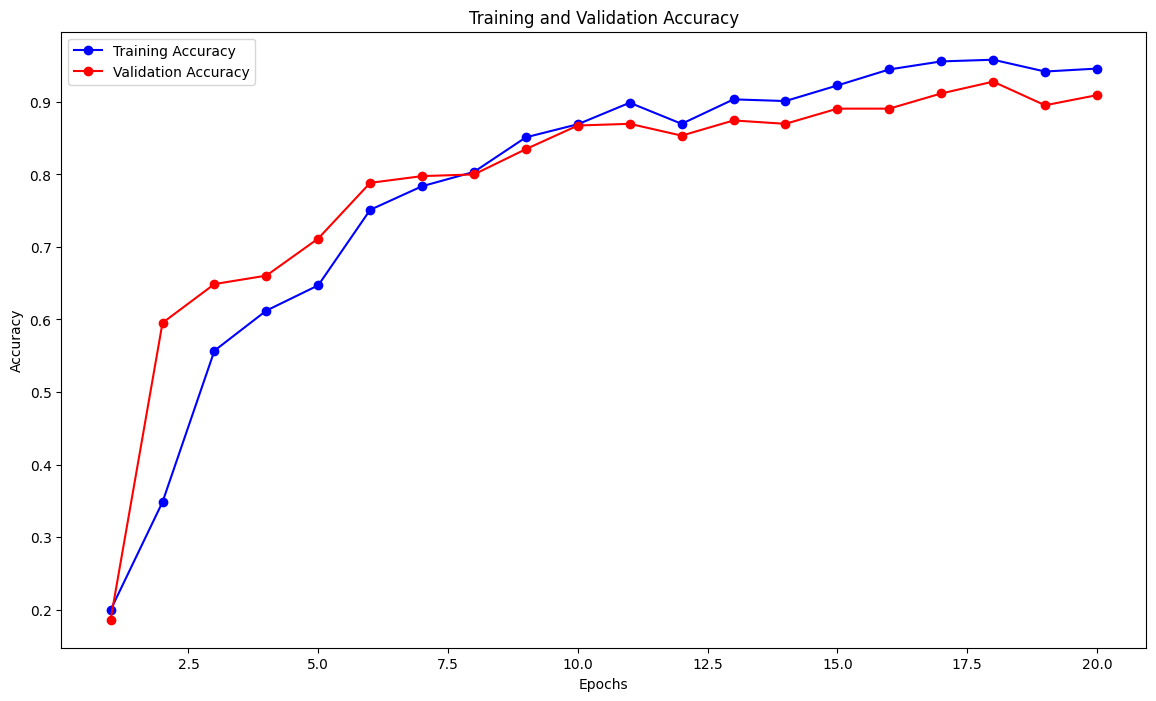

In [48]:
# Plotting the training and validation accuracy
plt.figure(figsize=(14, 8))
plt.plot(epochs_range, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

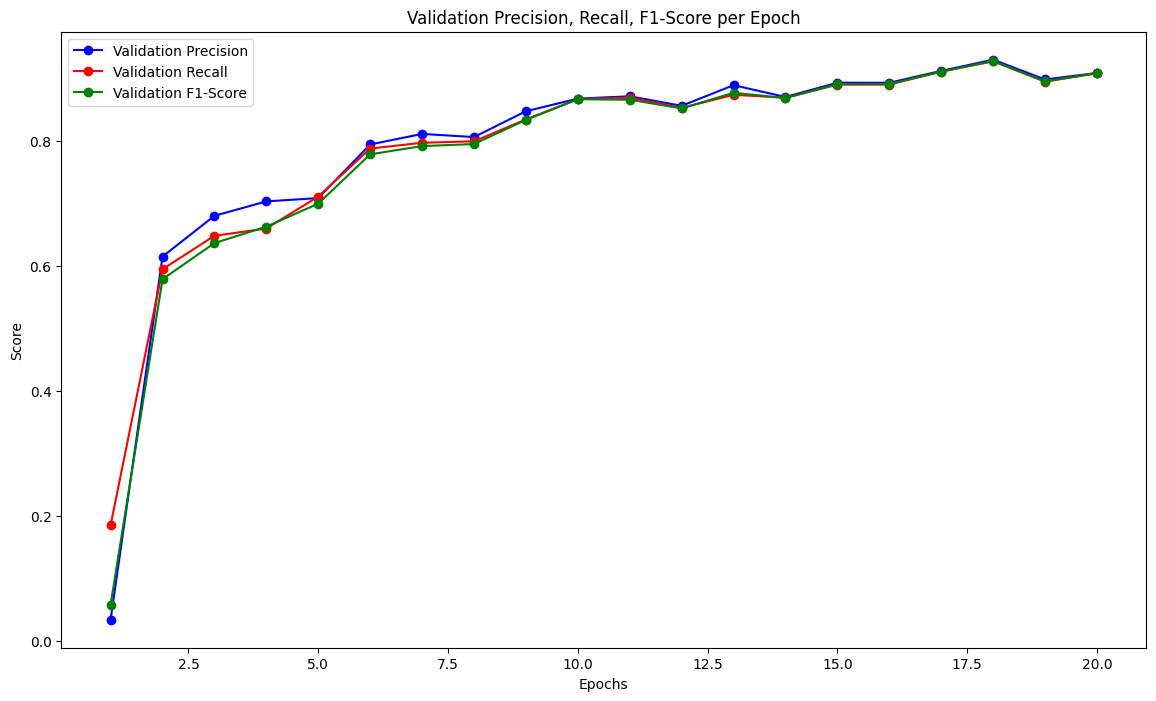

In [52]:
# Plotting the validation precision, recall, f1-score per epoch
plt.figure(figsize=(14, 8))
plt.plot(epochs_range, val_precision, 'bo-', label='Validation Precision')
plt.plot(epochs_range, val_recall, 'ro-', label='Validation Recall')
plt.plot(epochs_range, val_f1, 'go-', label='Validation F1-Score')
plt.title('Validation Precision, Recall, F1-Score per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.show()

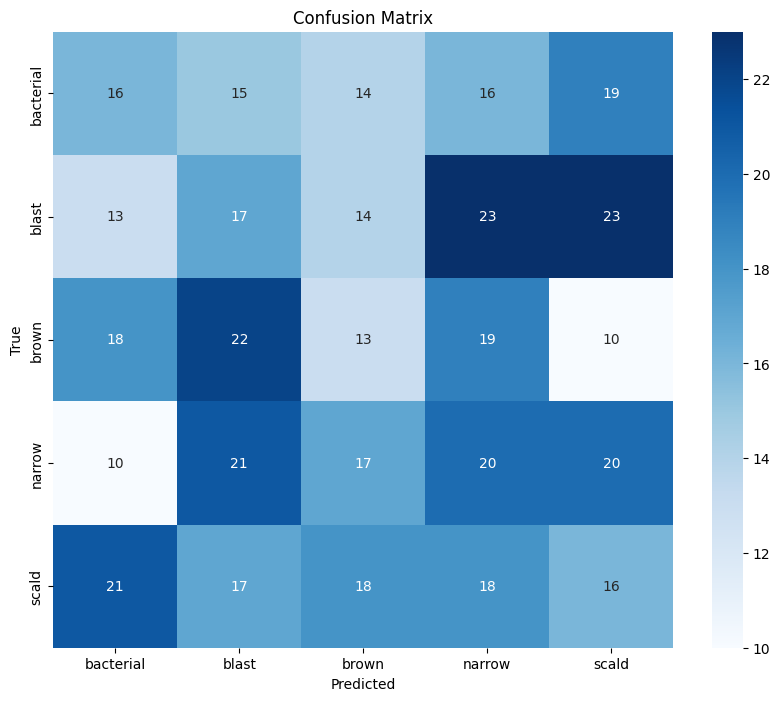

In [49]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()